# `GPflow` Gaussian Process Model of the Polydome Building

Base math/data packages

In [1]:
import numpy as np
import pandas as pd

Gaussian Process Modeling packages

In [2]:
import gpflow
import tensorflow as tf

In [3]:
from gpflow.utilities import print_summary

Print summary in notebook format:

In [4]:
gpflow.config.set_default_summary_fmt("notebook")

In [5]:
#tf.config.set_visible_devices([], 'GPU')

Plotting package

In [6]:
import matplotlib.pyplot as plt

Notebook output parameters

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

Enable horizontal scroll for print output

In [8]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

## Data pre-processing

### Load the Experimental measurements to fit a GP model

Experiments used for identification: 7 6 4 2

Experiments used for validation: 3 5 1

In [9]:
exp_id = 1

In [10]:
df_wdb = pd.read_pickle(f"../Data/Experimental_python/Exp{exp_id}_WDB.pkl")
df_wdb

,time,timestamp,zenith,azimuth,dni,dhi,OutsideTemp,Tsky_rad,relative_humidity,precipitation,cloud_index,pressure,wind_speed,wind_direction,aoi,incidence_main,incidence_second,poa_direct,poa_diffuse
0,0,201706012000,78.691622,290.430819,7.251337,59.908644,22.0,16.0,50,-9999,0.5,96300,0,-9999,78.691622,-9999,-9999,1.421911,59.908644
1,300,201706012005,79.489651,291.279501,7.672114,56.537088,22.0,16.0,50,-9999,0.5,96300,0,-9999,79.489651,-9999,-9999,1.399494,56.537088
2,600,201706012010,80.282334,292.130503,8.423139,53.492674,22.0,16.0,50,-9999,0.5,96300,0,-9999,80.282334,-9999,-9999,1.421769,53.492674
3,900,201706012015,81.069332,292.984123,52.657244,65.770239,22.0,16.0,50,-9999,0.5,96300,0,-9999,81.069332,-9999,-9999,8.174467,65.770239
4,1200,201706012020,81.850261,293.840653,94.364403,62.829177,22.0,16.0,50,-9999,0.5,96300,0,-9999,81.850261,-9999,-9999,13.377157,62.829177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,160500,201706031635,43.923091,252.722275,64.970386,314.462614,24.0,18.0,50,-9999,0.5,96300,0,-9999,43.923091,-9999,-9999,46.796324,314.462614
536,160800,201706031640,44.746130,253.882437,530.910153,219.485890,24.0,18.0,50,-9999,0.5,96300,0,-9999,44.746130,-9999,-9999,377.069871,219.485890
537,161100,201706031645,45.573942,255.018953,428.243363,250.653973,24.0,18.0,50,-9999,0.5,96300,0,-9999,45.573942,-9999,-9999,299.765305,250.653973
538,161400,201706031650,46.406107,256.133161,667.400308,167.328816,24.0,18.0,50,-9999,0.5,96300,0,-9999,46.406107,-9999,-9999,460.200780,167.328816


In [11]:
df_carnot = pd.read_pickle(f"../Data/CARNOT_output/Exp{exp_id}_full.pkl")

In [12]:
df_data = df_carnot.loc[:, ['Power', 'Setpoint', 'OutsideTemp', 'SupplyTemp', 'InsideTemp', 'SolRad']]
df_simulated = df_carnot.loc[:, 'SimulatedTemp']

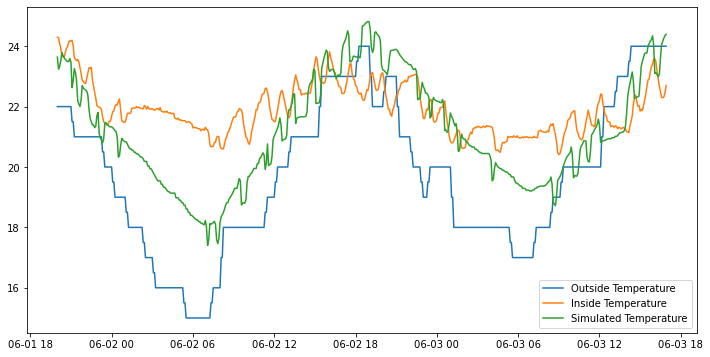

In [13]:
plt.figure()
plt.plot(df_data.index, df_data['OutsideTemp'], label = 'Outside Temperature')
plt.plot(df_data.index, df_data['InsideTemp'], label = 'Inside Temperature')
plt.plot(df_simulated.index, df_simulated, label = 'Simulated Temperature')
plt.legend()
plt.show()

### Combine the different dataframes into one

In [14]:
df = pd.concat([df_wdb, df_data.reset_index(), df_simulated.reset_index()], axis = 1)

Drop duplicated columns:

In [15]:
df = df.loc[:,~df.columns.duplicated()]

In [16]:
df

,time,timestamp,zenith,azimuth,dni,dhi,OutsideTemp,Tsky_rad,relative_humidity,precipitation,...,incidence_main,incidence_second,poa_direct,poa_diffuse,Power,Setpoint,SupplyTemp,InsideTemp,SolRad,SimulatedTemp
0,0,201706012000,78.691622,290.430819,7.251337,59.908644,22.0,16.0,50,-9999,...,-9999,-9999,1.421911,59.908644,4325.034483,23.5,24.5,24.300000,61.321333,23.639075
1,300,201706012005,79.489651,291.279501,7.672114,56.537088,22.0,16.0,50,-9999,...,-9999,-9999,1.399494,56.537088,4287.000000,23.5,15.5,24.283333,57.926100,23.243140
2,600,201706012010,80.282334,292.130503,8.423139,53.492674,22.0,16.0,50,-9999,...,-9999,-9999,1.421769,53.492674,4319.766667,23.5,15.2,24.083333,54.902033,23.335477
3,900,201706012015,81.069332,292.984123,52.657244,65.770239,22.0,16.0,50,-9999,...,-9999,-9999,8.174467,65.770239,2893.344828,23.5,14.9,23.933333,73.860700,23.524368
4,1200,201706012020,81.850261,293.840653,94.364403,62.829177,22.0,16.0,50,-9999,...,-9999,-9999,13.377157,62.829177,59.137931,23.5,18.2,23.666667,76.042533,23.793051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,160500,201706031635,43.923091,252.722275,64.970386,314.462614,24.0,18.0,50,-9999,...,-9999,-9999,46.796324,314.462614,62.137931,24.5,16.4,22.300000,361.247267,24.062549
536,160800,201706031640,44.746130,253.882437,530.910153,219.485890,24.0,18.0,50,-9999,...,-9999,-9999,377.069871,219.485890,57.482759,24.5,17.6,22.300000,596.456167,24.158706
537,161100,201706031645,45.573942,255.018953,428.243363,250.653973,24.0,18.0,50,-9999,...,-9999,-9999,299.765305,250.653973,56.233333,24.5,18.5,22.316667,550.335400,24.269707
538,161400,201706031650,46.406107,256.133161,667.400308,167.328816,24.0,18.0,50,-9999,...,-9999,-9999,460.200780,167.328816,53.379310,24.5,20.0,22.450000,627.393133,24.348123


Selected the potentially useful columns: 

In [17]:
df = df.loc[:, ['timestamp', 'zenith', 'azimuth', 'dni', 'dhi', 'OutsideTemp', 'Power', 'InsideTemp', 'SolRad', 'SimulatedTemp']]
df.rename(columns = {'timestamp': 'timestamp_int'}, inplace = True)
df.loc[:, 'timestamp'] = df_data.index
df.set_index('timestamp', drop = True, inplace = True)

In [18]:
df

,timestamp_int,zenith,azimuth,dni,dhi,OutsideTemp,Power,InsideTemp,SolRad,SimulatedTemp
timestamp,,,,,,,,,,
2017-06-01 20:00:00+02:00,201706012000,78.691622,290.430819,7.251337,59.908644,22.0,4325.034483,24.300000,61.321333,23.639075
2017-06-01 20:05:00+02:00,201706012005,79.489651,291.279501,7.672114,56.537088,22.0,4287.000000,24.283333,57.926100,23.243140
2017-06-01 20:10:00+02:00,201706012010,80.282334,292.130503,8.423139,53.492674,22.0,4319.766667,24.083333,54.902033,23.335477
2017-06-01 20:15:00+02:00,201706012015,81.069332,292.984123,52.657244,65.770239,22.0,2893.344828,23.933333,73.860700,23.524368
2017-06-01 20:20:00+02:00,201706012020,81.850261,293.840653,94.364403,62.829177,22.0,59.137931,23.666667,76.042533,23.793051
...,...,...,...,...,...,...,...,...,...,...
2017-06-03 16:35:00+02:00,201706031635,43.923091,252.722275,64.970386,314.462614,24.0,62.137931,22.300000,361.247267,24.062549
2017-06-03 16:40:00+02:00,201706031640,44.746130,253.882437,530.910153,219.485890,24.0,57.482759,22.300000,596.456167,24.158706
2017-06-03 16:45:00+02:00,201706031645,45.573942,255.018953,428.243363,250.653973,24.0,56.233333,22.316667,550.335400,24.269707


### Autoregressive inputs/outputs

In [19]:
df.rename(columns = {'Power': 'u', 'InsideTemp': 'y'}, inplace = True)
df

,timestamp_int,zenith,azimuth,dni,dhi,OutsideTemp,u,y,SolRad,SimulatedTemp
timestamp,,,,,,,,,,
2017-06-01 20:00:00+02:00,201706012000,78.691622,290.430819,7.251337,59.908644,22.0,4325.034483,24.300000,61.321333,23.639075
2017-06-01 20:05:00+02:00,201706012005,79.489651,291.279501,7.672114,56.537088,22.0,4287.000000,24.283333,57.926100,23.243140
2017-06-01 20:10:00+02:00,201706012010,80.282334,292.130503,8.423139,53.492674,22.0,4319.766667,24.083333,54.902033,23.335477
2017-06-01 20:15:00+02:00,201706012015,81.069332,292.984123,52.657244,65.770239,22.0,2893.344828,23.933333,73.860700,23.524368
2017-06-01 20:20:00+02:00,201706012020,81.850261,293.840653,94.364403,62.829177,22.0,59.137931,23.666667,76.042533,23.793051
...,...,...,...,...,...,...,...,...,...,...
2017-06-03 16:35:00+02:00,201706031635,43.923091,252.722275,64.970386,314.462614,24.0,62.137931,22.300000,361.247267,24.062549
2017-06-03 16:40:00+02:00,201706031640,44.746130,253.882437,530.910153,219.485890,24.0,57.482759,22.300000,596.456167,24.158706
2017-06-03 16:45:00+02:00,201706031645,45.573942,255.018953,428.243363,250.653973,24.0,56.233333,22.316667,550.335400,24.269707


Add input lags:

In [20]:
lu = 1

for idx in range(1, lu + 1):
    df[f"u_{idx}"] = df['u'].shift(idx)

Add output lags:

In [21]:
ly = 3

for idx in range(1, ly + 1):
    df[f"y_{idx}"] = df['y'].shift(idx)

In [22]:
df.dropna(inplace = True)

In [23]:
df

,timestamp_int,zenith,azimuth,dni,dhi,OutsideTemp,u,y,SolRad,SimulatedTemp,u_1,y_1,y_2,y_3
timestamp,,,,,,,,,,,,,,
2017-06-01 20:15:00+02:00,201706012015,81.069332,292.984123,52.657244,65.770239,22.0,2893.344828,23.933333,73.860700,23.524368,4319.766667,24.083333,24.283333,24.300000
2017-06-01 20:20:00+02:00,201706012020,81.850261,293.840653,94.364403,62.829177,22.0,59.137931,23.666667,76.042533,23.793051,2893.344828,23.933333,24.083333,24.283333
2017-06-01 20:25:00+02:00,201706012025,82.624676,294.700379,72.713713,55.785907,22.0,58.241379,23.650000,64.981967,23.690749,59.137931,23.666667,23.933333,24.083333
2017-06-01 20:30:00+02:00,201706012030,83.392049,295.563581,24.601803,43.887954,22.0,59.000000,23.633333,46.667567,23.616543,58.241379,23.650000,23.666667,23.933333
2017-06-01 20:35:00+02:00,201706012035,84.151733,296.430536,11.237512,33.883988,22.0,61.103448,23.800000,35.002967,23.566295,59.000000,23.633333,23.650000,23.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-03 16:35:00+02:00,201706031635,43.923091,252.722275,64.970386,314.462614,24.0,62.137931,22.300000,361.247267,24.062549,4348.068966,22.500000,22.683333,22.900000
2017-06-03 16:40:00+02:00,201706031640,44.746130,253.882437,530.910153,219.485890,24.0,57.482759,22.300000,596.456167,24.158706,62.137931,22.300000,22.500000,22.683333
2017-06-03 16:45:00+02:00,201706031645,45.573942,255.018953,428.243363,250.653973,24.0,56.233333,22.316667,550.335400,24.269707,57.482759,22.300000,22.300000,22.500000


### Formalize everything into a function

In [24]:
def load_autoregressive_df(exp_id, lu = 1, ly = 3):
    
    df_wdb = pd.read_pickle(f"../Data/Experimental_python/Exp{exp_id}_WDB.pkl")
    
    df_carnot = pd.read_pickle(f"../Data/CARNOT_output/Exp{exp_id}_full.pkl")
    df_data = df_carnot.loc[:, ['Power', 'Heat', 'Setpoint', 'OutsideTemp', 'SupplyTemp', 'InsideTemp', 'SolRad']]
    df_simulated = df_carnot.loc[:, 'SimulatedTemp']

    df = pd.concat([df_wdb, df_data.reset_index(), df_simulated.reset_index()], axis = 1)

    df = df.loc[:,~df.columns.duplicated()]
    
    # Select the potentially useful columns
    #df = df.loc[:, ['timestamp', 'zenith', 'azimuth', 'dni', 'dhi', 'OutsideTemp', 'Power', 'InsideTemp', 'SolRad', 'Setpoint']]
    df = df.loc[:, ['timestamp','SolRad', 'OutsideTemp', 'Heat', 'InsideTemp']]

    df.drop(columns = ['timestamp'], inplace = True)
    df.loc[:, 'timestamp'] = df_data.index
    df.set_index('timestamp', drop = True, inplace = True)
    
    # Select the input/output and drop the columns that doesn't make to be used
    dyn_in = 'Heat'
    dyn_out = 'InsideTemp'    
    df.rename(columns = {dyn_in: 'u', dyn_out: 'y'}, inplace = True)

    # Add the regressive inputs/outputs
    for idx in range(1, lu + 1):
        df[f"u_{idx}"] = df['u'].shift(idx)
        
    for idx in range(1, ly + 1):
        df[f"y_{idx}"] = df['y'].shift(idx)
        
    # Since some lines now have holes, drop them
    df.dropna(inplace = True)
    
    return df

In [25]:
#lu = 1, ly = 3 defined in a preceding cell
df_compiled = load_autoregressive_df(1, lu = lu, ly = ly)
for idx in [2,4,6,7]:
    df_compiled = df_compiled.append(load_autoregressive_df(idx, lu = lu, ly = ly))
df_compiled

,SolRad,OutsideTemp,u,y,u_1,y_1,y_2,y_3
timestamp,,,,,,,,
2017-06-01 20:15:00+02:00,73.860700,22.0,-8680.034483,23.933333,-12959.300000,24.083333,24.283333,24.300000
2017-06-01 20:20:00+02:00,76.042533,22.0,-177.413793,23.666667,-8680.034483,23.933333,24.083333,24.283333
2017-06-01 20:25:00+02:00,64.981967,22.0,-174.724138,23.650000,-177.413793,23.666667,23.933333,24.083333
2017-06-01 20:30:00+02:00,46.667567,22.0,59.000000,23.633333,-174.724138,23.650000,23.666667,23.933333
2017-06-01 20:35:00+02:00,35.002967,22.0,61.103448,23.800000,59.000000,23.633333,23.650000,23.666667
...,...,...,...,...,...,...,...,...
2017-07-20 05:35:00+02:00,3.260000,22.0,-28.551724,22.766667,-27.931034,22.750000,22.733333,22.750000
2017-07-20 05:40:00+02:00,3.250000,22.0,-17.000000,22.733333,-28.551724,22.766667,22.750000,22.733333
2017-07-20 05:45:00+02:00,3.240000,22.0,-27.413793,22.750000,-17.000000,22.733333,22.766667,22.750000


## Gaussian Process fitting

In [26]:
from sklearn.preprocessing import RobustScaler

In [27]:
x_scaler = RobustScaler()

### Sample the training data from the whole dataset

In [28]:
df_sampled = df_compiled.sample(n = 150)

Save the dataset since it's needed when loading the model from saved files:

In [29]:
df_sampled.to_pickle("gp_trainset.pkl")

In [30]:
df_input = df_sampled.drop(columns = ['y'])
df_output = df_sampled['y']

In [31]:
np_input = df_input.to_numpy()
np_output = df_output.to_numpy().reshape(-1, 1)

Scale the data:

In [32]:
np_input_sc = x_scaler.fit_transform(np_input)

In [88]:
k = gpflow.kernels.SquaredExponential(lengthscales=([1] * np_input.shape[1])) + gpflow.kernels.Constant() + gpflow.kernels.White()
k = gpflow.kernels.SquaredExponential(lengthscales=([1] * np_input.shape[1])) + gpflow.kernels.Constant()
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
Sum.kernels[0].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[1., 1., 1...."
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0


In [89]:
m = gpflow.models.GPR(
    data = (np_input_sc, np_output), 
    kernel = k, 
    mean_function = None
    )
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[1., 1., 1...."
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [90]:
opt = gpflow.optimizers.Scipy()

In [91]:
from datetime import datetime

In [92]:
start_time = datetime.now()
opt.minimize(m.training_loss, m.trainable_variables)
print(f"Finished fitting in {datetime.now() - start_time}")
print_summary(m)

Finished fitting in 0:00:01.800025


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,522.3146176324312
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[398.28296795, 262.16471714, 1574.2697205..."
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,600.9888765600585
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.005945197285215412


In [93]:
test_day = 5
df_test = load_autoregressive_df(test_day, lu = lu, ly = ly)
np_test_in = df_test.drop(columns = ['y']).to_numpy()
np_test_in_sc = x_scaler.transform(np_test_in)
np_test_out = df_test['y'].to_numpy().reshape(-1, 1)

In [94]:
mean, var = m.predict_f(np_test_in_sc)

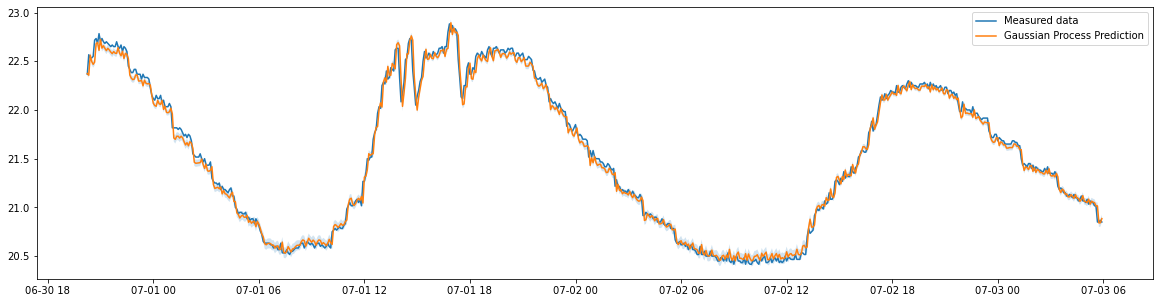

In [95]:
plt.figure(figsize = (20, 5))
plt.plot(df_test.index, np_test_out[:, :], label = 'Measured data')
plt.plot(df_test.index, mean[:, :], label = 'Gaussian Process Prediction')
plt.fill_between(
    df_test.index, 
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    alpha = 0.2
)
plt.legend()
plt.show()

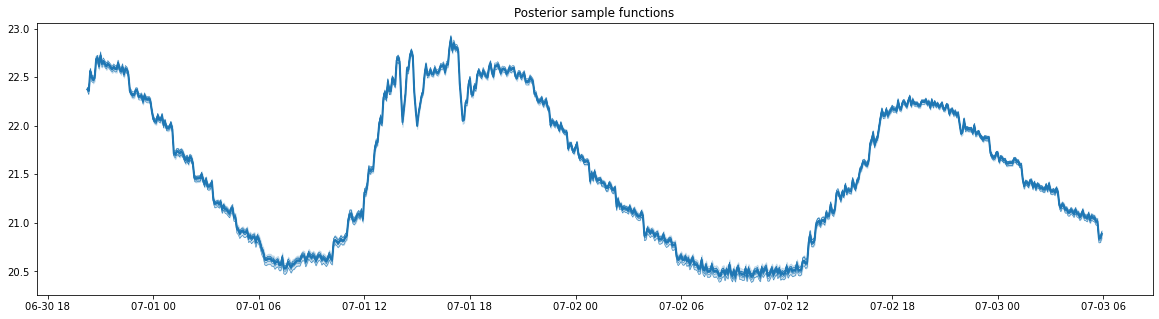

In [96]:
## generate test points for prediction
xx = x_scaler.transform(np_test_in)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(20, 5))
plt.title('Posterior sample functions')
plt.plot(df_test.index, mean, "C0", lw=2)
plt.fill_between(
    df_test.index,
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
plt.plot(df_test.index, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
#plt.plot(df_test.index, np_test_out[:, :], ':', color = 'darkorange', lw = 2)
#_ = plt.ylim(21, 23.5)
plt.show()

In [97]:
err = abs(np_test_out - mean)

In [98]:
np.max(var)

0.0008520598721588613

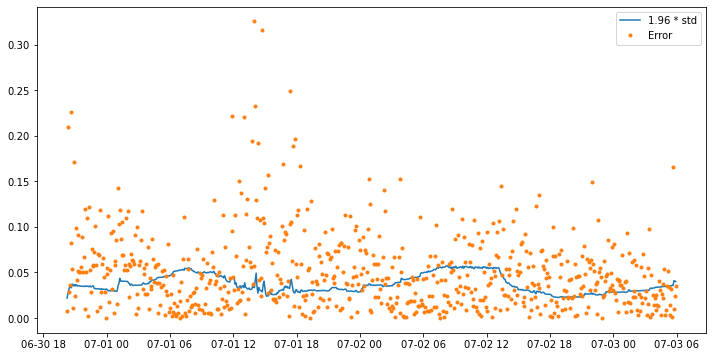

In [99]:
plt.figure()
plt.plot(df_test.index, 1.96 * np.sqrt(var), label = '1.96 * std')
plt.plot(df_test.index, err, '.', label = 'Error')
plt.legend()
plt.show()

In [85]:
big_err = (err > 1.96*np.sqrt(var)).numpy().sum()
print(big_err)

17


In [86]:
1 - big_err/len(err)

0.9754689754689755

### Export the fitted model

In [45]:
from pathlib import Path
import pickle

In [46]:
m_params = gpflow.utilities.parameter_dict(m)

In [47]:
pickle.dump(m_params, open(Path(Path.cwd(), 'gp_params.gpf'), 'wb'))

In [48]:
pickle.dump(x_scaler, open(Path(Path.cwd(), 'x_scaler.pkl'), 'wb'))

### Re-import the model and compare prediction with first model

In [49]:
k_loaded = gpflow.kernels.SquaredExponential(lengthscales=([1] * np_input.shape[1])) + gpflow.kernels.Constant()

In [50]:
m_loaded = gpflow.models.GPR(
    data = (np_input_sc, np_output), 
    kernel = k_loaded,
    mean_function = None
    )

In [51]:
m_params_loaded = pickle.load(open(Path(Path.cwd(), 'gp_params.gpf'), 'rb'))

In [52]:
gpflow.utilities.multiple_assign(m_loaded, m_params_loaded)

In [53]:
mean_loaded, var_loaded = m_loaded.predict_f(np_test_in_sc)

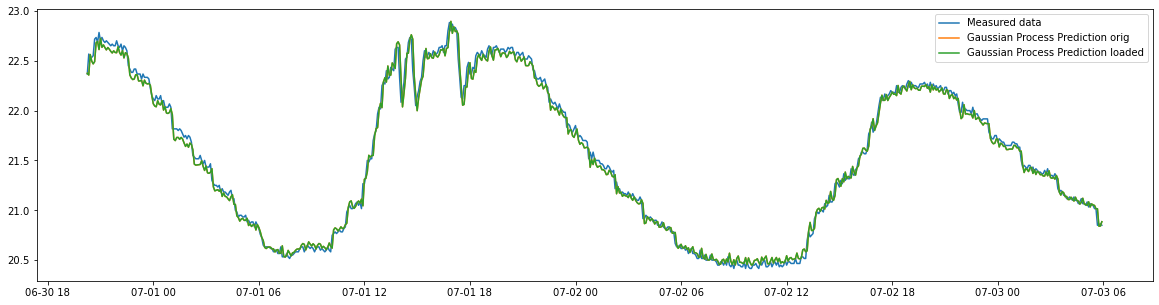

In [54]:
plt.figure(figsize = (20, 5))
plt.plot(df_test.index, np_test_out[:, :], label = 'Measured data')
plt.plot(df_test.index, mean[:, :], label = 'Gaussian Process Prediction orig')
plt.plot(df_test.index, mean_loaded[:, :], label = 'Gaussian Process Prediction loaded')
plt.legend()
plt.show()

In [101]:
df_sampled

,SolRad,OutsideTemp,u,y,u_1,y_1,y_2,y_3
timestamp,,,,,,,,
2017-07-19 15:05:00+02:00,680.640000,28.0,-14422.100000,22.583333,-14336.689655,22.600000,22.733333,22.783333
2017-06-22 02:25:00+02:00,3.403067,28.0,-62.586207,22.566667,-90.517241,22.600000,22.650000,22.833333
2017-07-16 13:45:00+02:00,885.935000,21.0,-12772.700000,22.716667,-13091.586207,22.866667,22.850000,22.633333
2017-07-15 03:50:00+02:00,3.090000,18.0,-13.233333,21.566667,-12.758621,21.516667,21.533333,21.558333
2017-07-18 07:05:00+02:00,91.620000,19.0,-5.793103,22.566667,6.517241,22.533333,22.566667,22.566667
...,...,...,...,...,...,...,...,...
2017-06-11 13:20:00+02:00,916.328067,22.5,2138.344828,23.100000,-15974.793103,23.200000,23.383333,23.583333
2017-07-19 16:05:00+02:00,450.750000,28.0,-14195.275862,22.833333,-14086.500000,23.000000,23.033333,23.166667
2017-07-15 20:30:00+02:00,95.620000,22.0,-6755.379310,23.066667,-2.793103,22.833333,22.833333,22.633333
